# Description

This notebook calculates the Bayesian posterior distribution of the binomial single trial success probability, given the number of conducted tests ```n_trials``` and the number of successful tests ```n_successes``` out of these, using a uniform prior distribution.

This notebook produces a graph that tells you how much belief you can put into any of the possible single trial success probabilities between 0 (always fails) and 1 (always succeeds) after having done a test with ```n_trials``` trials of which ```n_successes``` were successful. This result depends on a so-called prior distribution that models your belief in different possible single trial success probabilities before the test. By default we choose a uniform prior, since this does not skew the results (the maximum belief will be for exactly the success rate of your test run).

__Note__
1. All probabilities are given as numbers between 0 and 1, where 0 represents "never" and 1 represents 100% certainty.
2. The calculated degree of belief is __NOT__ conservative. It depends on the chosen prior and can be both too high and too low.

# Parameters

In [1]:
n_trials = 10
n_successes = 9

assert isinstance(n_trials, int) and n_trials >= 0
assert isinstance(n_successes, int) and 0 <= n_successes <= n_trials

# Evaluation

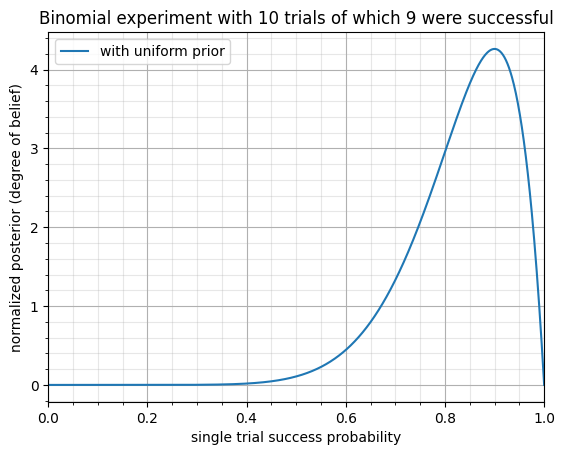

In [2]:
import matplotlib.pyplot as plt
import mpmath as mp
import numpy as np
from scipy import integrate

mp.mp.dps = 50 #use 50 decimal digits precision in mpmath calculations

def posterior_prob_binom_p(p, n_trials, n_successes, prior):
    return mp.power(mp.mpf(p), n_successes) * mp.power(mp.mpf(1-p), (n_trials-n_successes)) * prior(p)

posterior_prob_binom_p_vectorized = np.vectorize(posterior_prob_binom_p)

#split the integral into constant and non-constant parts and prescale so numerical integration does not fail due to sharp peak for large n_trial
def integrate_posterior_prob_binom_p_norm(n_trials, n_successes, prior, bounds):
    mean = (n_successes+1) / (n_trials+2)
    std_dev = ( (n_successes+1)*(n_trials-n_successes+1) / ((n_trials+2)**2*(n_trials+3)) )**0.5
    prescale = 1/posterior_prob_binom_p(mean,n_trials, n_successes, prior)
    prior_prescaled = lambda p: prior(p) * prescale
    
    norm = 0
    if bounds[0] < mean-3*std_dev:
        norm += integrate.quad(posterior_prob_binom_p, max(0, bounds[0]), min(mean-3*std_dev, bounds[1]), args=(n_trials, n_successes, prior_prescaled))[0]
    if bounds[0] < mean and bounds[1] >= mean-3*std_dev:
        norm += integrate.quad(posterior_prob_binom_p, max(mean-3*std_dev, bounds[0]), min(mean, bounds[1]), args=(n_trials, n_successes, prior_prescaled))[0]
    if bounds[0] < mean+3*std_dev and bounds[1] >= mean:
        norm += integrate.quad(posterior_prob_binom_p, max(mean, bounds[0]), min(mean+3*std_dev, bounds[1]), args=(n_trials, n_successes, prior_prescaled))[0]
    if bounds[0] < 1 and bounds[1] >= mean+3*std_dev:
        norm += integrate.quad(posterior_prob_binom_p, max(mean+3*std_dev, bounds[0]), min(1, bounds[1]), args=(n_trials, n_successes, prior_prescaled))[0]
        
    return norm / prescale

xlim_lo = 0.0 #change plot range here
xlim_hi = 1.0
p = np.linspace(xlim_lo, xlim_hi, 1001)

prior = lambda p: 1
posterior_probs = posterior_prob_binom_p_vectorized(p, n_trials, n_successes, prior) / integrate_posterior_prob_binom_p_norm(n_trials, n_successes, prior, [0, 1])
plt.plot(p, posterior_probs, label='with uniform prior')

# prior = lambda p: (p*(1-p))**0.5
# posterior_probs = posterior_prob_binom_p_vectorized(p, n_trials, n_successes, prior) / integrate_posterior_prob_binom_p_norm(n_trials, n_successes, prior, [0, 1])
# plt.plot(p, posterior_probs, label='with Jeffrey\'s prior')
# plt.plot(p, prior(p), label='Jeffrey\'s prior')

plt.gca().set_title('Binomial experiment with {} trials of which {} were successful'.format(n_trials, n_successes))
plt.gca().set_xlabel('single trial success probability')
plt.gca().set_ylabel('normalized posterior (degree of belief)')
plt.gca().tick_params(axis='x', which='minor', bottom=True)
plt.gca().minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', alpha=0.3);
plt.legend()

plt.gca().set_xlim([xlim_lo, xlim_hi]); #change plot range here